### Do proper encoding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
def evaluate_model(model, X_test, y_test, cmap='Greens'):
    """
    Generates and displays a full evaluation suite for a classification model.
    """
    print("Evaluating the model on the test set...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n## Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [6]:
data = pd.read_csv('/Users/sanchitwani/Documents/Done/Insurance Fraud/3 Try/cleaned_3_insurance.csv')

In [7]:
data_tree = data.copy()

In [8]:
data_tree.columns

Index(['months_as_customer', 'age', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_occupation', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type',
       'authorities_contacted', 'incident_state', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'fraud_reported', 'claim_severity_ratio', 'injury_ratio',
       'vehicle_ratio', 'from_bind_to_incident_months', 'is_high_risk_hobby',
       'incident_severity_encoded', 'claim_x_tenure'],
      dtype='object')

In [9]:
data.head()

months_as_customer  age policy_csl  policy_deductable  \
0                 328   48    250/500               1000   
1                 228   42    250/500               2000   
2                 134   29    100/300               2000   
3                 256   41    250/500               2000   
4                 228   44   500/1000               1000   

   policy_annual_premium  umbrella_limit insured_sex insured_occupation  \
0                1406.91               0        MALE       craft-repair   
1                1197.22         5000000        MALE  machine-op-inspct   
2                1413.14         5000000      FEMALE              sales   
3                1415.74         6000000      FEMALE       armed-forces   
4                1583.91         6000000        MALE              sales   

  insured_relationship  capital-gains  ...  total_claim_amount  auto_make  \
0              husband          53300  ...               71610       Saab   
1       other-relative              0  ...                5070   Mercedes   
2            own-child          35100  ...               34650      Dodge   
3            unmarried          48900  ...               63400  Chevrolet   
4            unmarried          66000  ...                6500     Accura   

  fraud_reported claim_severity_ratio injury_ratio  vehicle_ratio  \
0              1            50.898778     0.090909       0.727273   
1              1             4.234811     0.153846       0.692308   
2              0            24.519864     0.222222       0.666667   
3              1            44.782234     0.100000       0.800000   
4              0             4.103769     0.200000       0.700000   

   from_bind_to_incident_months is_high_risk_hobby  incident_severity_encoded  \
0                             3                  0                          2   
1                           102                  0                          1   
2                           173                  0                          1   
3                           295                  0                          2   
4                             8                  0                          1   

   claim_x_tenure  
0          214830  
1          517140  
2         5994450  
3        18703000  
4           52000  

[5 rows x 31 columns]

In [10]:
categorical_cols = data_tree.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data_tree[col] = le.fit_transform(data_tree[col])

In [11]:
# --- 1. Split ---
X = data_tree.drop('fraud_reported', axis=1)
y = data_tree['fraud_reported']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Decison Tree

In [13]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

In [14]:
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [15]:
# Initialize GridSearchCV
# We optimize for 'f1' score, which is good for imbalanced classes
grid_search = GridSearchCV(estimator=dt_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1, 
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='f1', verbose=1)

In [16]:
print("\nGridSearchCV complete.")
print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best F1-score on cross-validation: {grid_search.best_score_:.4f}\n")

best_dt_model = grid_search.best_estimator_


GridSearchCV complete.
Best Parameters found: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best F1-score on cross-validation: 0.7557



Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       151
           1       0.64      0.86      0.73        49

    accuracy                           0.84       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.87      0.84      0.85       200

Accuracy: 0.84
ROC AUC Score: 0.8405


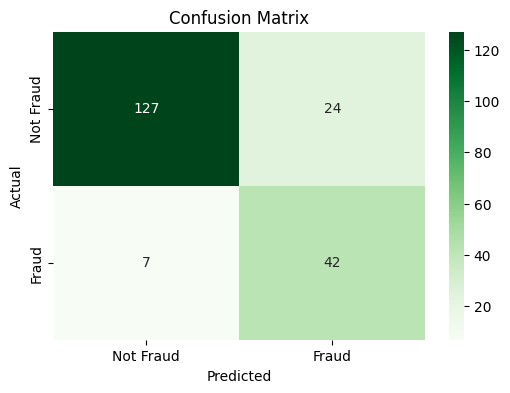

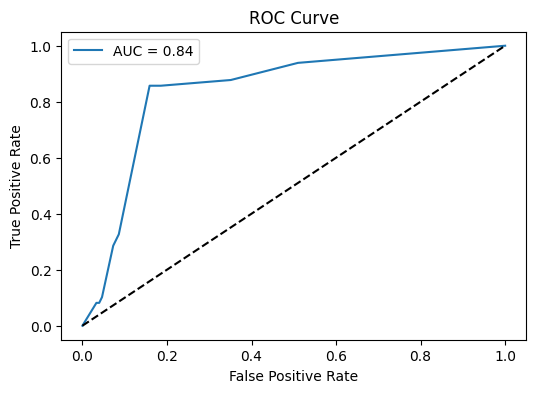

In [17]:
evaluate_model(best_dt_model, X_test, y_test)

### Random Forest

In [18]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [19]:
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

In [20]:
# Initialize GridSearchCV to find the best model based on F1-score
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           verbose=2)

In [21]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, crite

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [22]:
## Display Best Parameters and Evaluate the Best Model
print("\nGridSearchCV complete.")
print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best F1-score on cross-validation: {grid_search.best_score_:.4f}\n")


GridSearchCV complete.
Best Parameters found: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-score on cross-validation: 0.7557



In [23]:
# Get the single best model found by the grid search
best_rf_model = grid_search.best_estimator_


Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       151
           1       0.64      0.86      0.73        49

    accuracy                           0.84       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.87      0.84      0.85       200

Accuracy: 0.84
ROC AUC Score: 0.8357


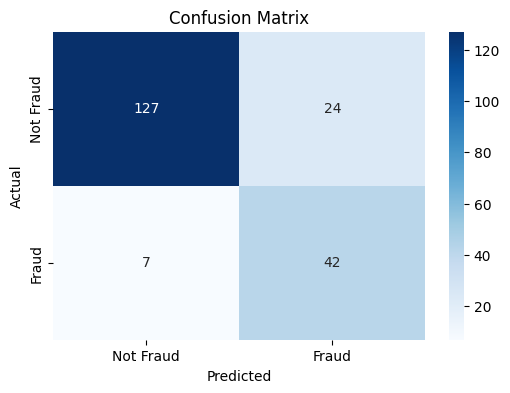

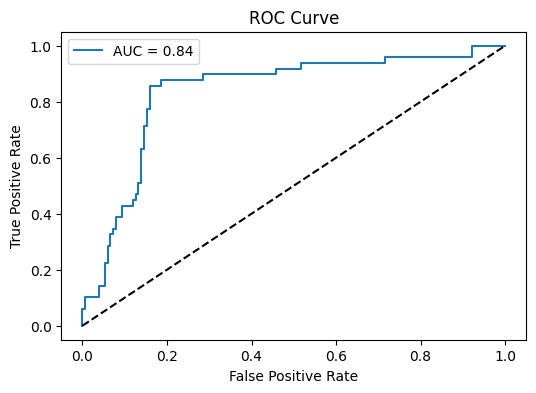

In [24]:
# Use the same evaluation function to see the final performance
evaluate_model(best_rf_model, X_test, y_test, cmap='Blues')

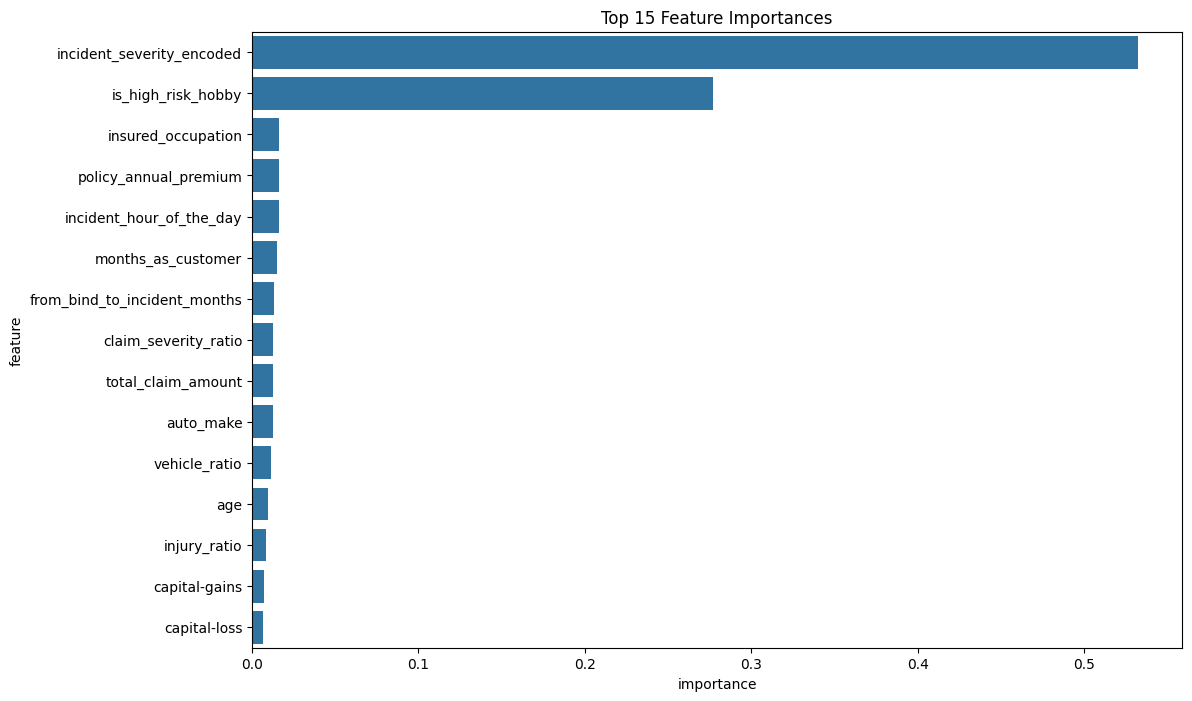

In [25]:
# This assumes you have your trained 'best_rf_model' (or any tree model)
# and your training data 'X_train'

# 1. Get feature importances from your best model
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15)) # Plot top 15
plt.title('Top 15 Feature Importances')
plt.show()


### Gradient Boosting

In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

In [31]:
gb_classifier = GradientBoostingClassifier(random_state=42)

In [32]:
grid_search = GridSearchCV(estimator=gb_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           verbose=2, 
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END lea

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [33]:
best_gb_model = grid_search.best_estimator_

In [54]:
best_gb_model

GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=5,
                           random_state=42)

Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       151
           1       0.61      0.47      0.53        49

    accuracy                           0.80       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.78      0.80      0.79       200

Accuracy: 0.80
ROC AUC Score: 0.8323


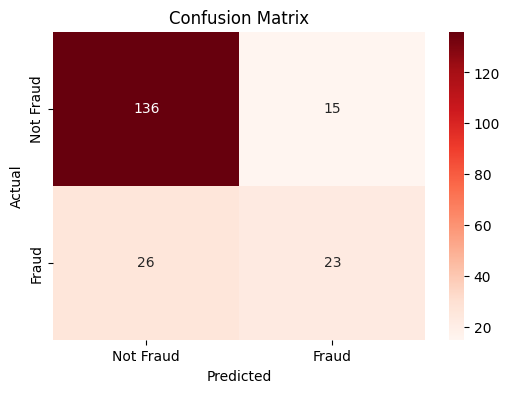

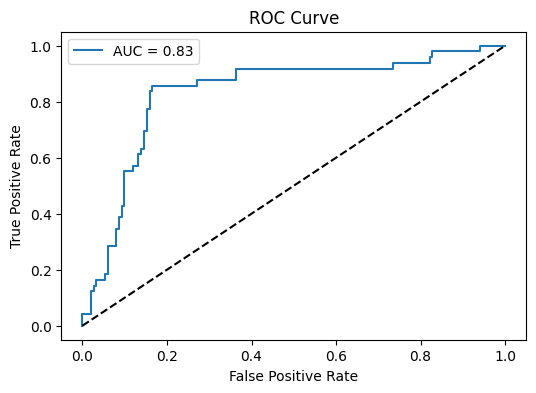

In [36]:
evaluate_model(best_gb_model, X_test, y_test, cmap='Reds')

### XGBoost

In [37]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [38]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [43]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                   eval_metric='logloss',
                                   scale_pos_weight=scale_pos_weight,
                                   random_state=42)

In [44]:
grid_search = GridSearchCV(estimator=xgb_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=2,
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END c

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [45]:
print("\nGridSearchCV complete.")
print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best F1-score on cross-validation: {grid_search.best_score_:.4f}\n")


GridSearchCV complete.
Best Parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best F1-score on cross-validation: 0.7492



In [46]:
best_xgb_model = grid_search.best_estimator_

Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       151
           1       0.63      0.84      0.72        49

    accuracy                           0.84       200
   macro avg       0.79      0.84      0.80       200
weighted avg       0.86      0.84      0.85       200

Accuracy: 0.84
ROC AUC Score: 0.8296


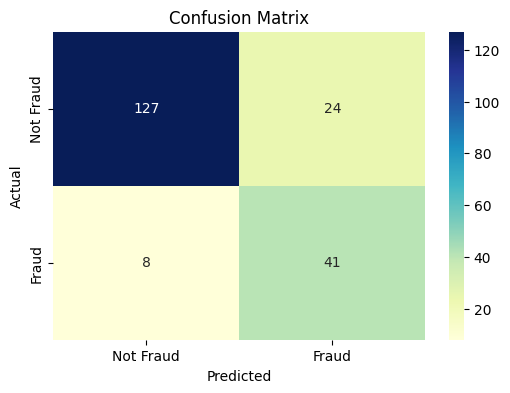

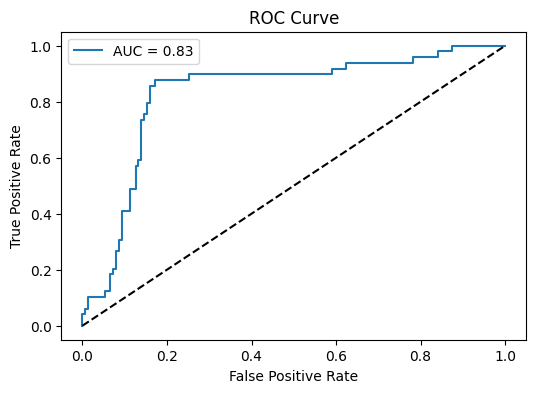

In [47]:
evaluate_model(best_xgb_model, X_test, y_test, cmap='YlGnBu')

### LightGBM

In [48]:
import lightgbm as lgb

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],          # A key parameter for LightGBM's complexity
    'max_depth': [-1, 10, 15],       # -1 means no limit
    'subsample': [0.8, 1.0],         # Fraction of rows per tree
    'colsample_bytree': [0.8, 1.0]   # Fraction of columns per tree
}

In [49]:
lgb_classifier = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

In [50]:
grid_search = GridSearchCV(estimator=lgb_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=2,
                           n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 158, number of negative: 482
[LightGBM] [Info] Number of positive: 159, number of negative: 481
[LightGBM] [Info] Number of positive: 159, number of negative: 481
[LightGBM] [Info] Number of positive: 158, number of negative: 482
[LightGBM] [Info] Number of positive: 159, number of negative: 481
[LightGBM] [Info] Number of positive: 158, number of negative: 482
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info

/opt/anaconda3/envs/python_env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [-1, 10, 15], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [51]:
print("\nGridSearchCV complete.")
print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best F1-score on cross-validation: {grid_search.best_score_:.4f}\n")


GridSearchCV complete.
Best Parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
Best F1-score on cross-validation: 0.7034



In [52]:
best_lgb_model = grid_search.best_estimator_

Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       151
           1       0.62      0.73      0.67        49

    accuracy                           0.82       200
   macro avg       0.76      0.79      0.78       200
weighted avg       0.84      0.82      0.83       200

Accuracy: 0.82
ROC AUC Score: 0.8313


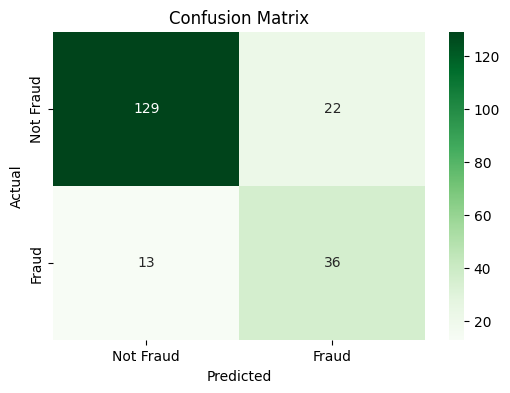

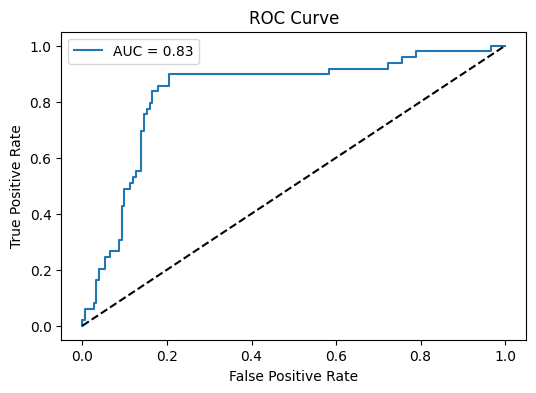

In [53]:
evaluate_model(best_lgb_model, X_test, y_test)

### Voting Classifier

Initializing best models for the ensemble...

Training the Voting Classifier...
Training complete.

Evaluating the model on the test set...

## Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       151
           1       0.64      0.86      0.73        49

    accuracy                           0.84       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.87      0.84      0.85       200

Accuracy: 0.84
ROC AUC Score: 0.8415


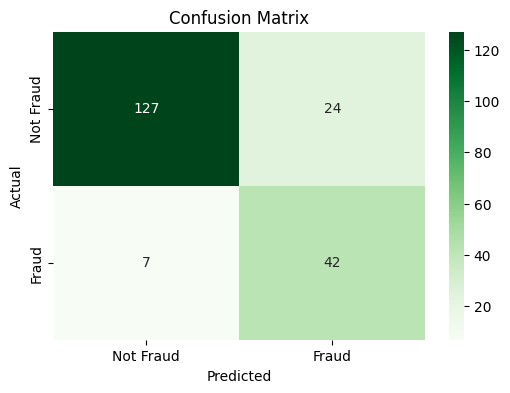

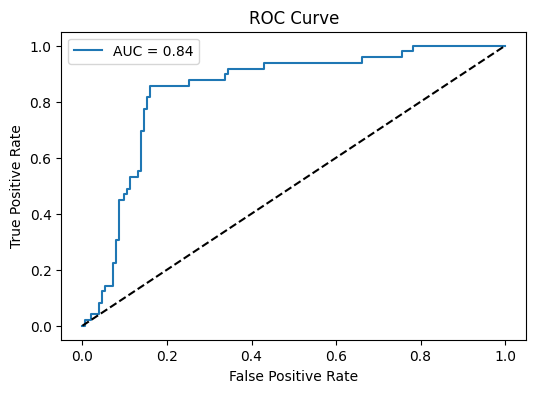

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# This assumes X_train, X_test, y_train, y_test are already created
# from the label-encoded data, and the evaluate_model function is defined.

# 1. Initialize your best-tuned models with the optimal parameters you found
print("Initializing best models for the ensemble...")

# Best Decision Tree
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                              min_samples_leaf=10, min_samples_split=2,
                              random_state=42, class_weight='balanced')

# Best Random Forest
# Note: The 'bootstrap' and 'max_features' parameters from your output are often defaults
# or determined by other settings, but we include them for completeness.
clf2 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5,
                              min_samples_leaf=4, min_samples_split=2, 
                              max_features='sqrt', # The default, not 'None'
                              random_state=42, class_weight='balanced', n_jobs=-1)

# Best XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
clf3 = xgb.XGBClassifier(colsample_bytree=1.0, learning_rate=0.05, max_depth=3,
                         n_estimators=100, subsample=0.8,
                         objective='binary:logistic', eval_metric='logloss',
                         scale_pos_weight=scale_pos_weight, random_state=42)

# 2. Create the Voting Classifier
# We use 'soft' voting to average the models' prediction probabilities
voting_clf = VotingClassifier(
    estimators=[('dt', clf1), ('rf', clf2), ('xgb', clf3)],
    voting='soft',
    n_jobs=-1
)

# 3. Train and Evaluate the Ensemble
print("\nTraining the Voting Classifier...")
voting_clf.fit(X_train, y_train)
print("Training complete.\n")

evaluate_model(voting_clf, X_test, y_test)

| Model | Accuracy (%) | Precision | Recall | F1-Score | ROC-AUC |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Decision Tree** | 84.00% | 0.64 | 0.86 | 0.73 | 0.841 |
| **Random Forest** | 84.00% | 0.64 | 0.86 | 0.73 | 0.836 |
| **Gradient Boosting** | 80.00% | 0.61 | 0.47 | 0.53 | 0.832 |
| **XGBoost** | 84.00% | 0.63 | 0.84 | 0.72 | 0.830 |
| **LightGBM** | 82.00% | 0.62 | 0.73 | 0.67 | 0.831 |
| **Voting Classifier**| 84.00% | 0.64 | 0.86 | 0.73 | **0.842**|